# TODO DOCUMENTAT

# Install

In [ ]:
# !pip install -q "monai-weekly[nibabel, skimage, scipy, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil, cucim, openslide, pandas, einops, transformers, mlflow, clearml, matplotlib, tensorboardX, tifffile, imagecodecs, pyyaml, fire, jsonschema, ninja, pynrrd, pydicom, h5py, nni, optuna, onnx, onnxruntime, zarr, lpips, pynvml, huggingface_hub]"

# Import libraries

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
# monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import first, set_determinism
from monai.networks.nets import UNet, DynUNet, AttentionUnet, ViTAutoEnc, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU, compute_average_surface_distance
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
#     RandDeformD,
    ToTensorD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# For UNETR
from torch.optim import AdamW
from monai.data import decollate_batch
from monai.losses import DiceCELoss

In [4]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 1


print(f'You are using {device}')

You are using cuda


### Hyperparameters

In [127]:
BATCH_SIZE = 4

IMG_HEIGHT = 128
IMG_WIDTH = 128
COLOUR_CHANNELS = 1
NO_STACKED_IMGS = 64

In [128]:
print(f'Running device: {torch.cuda.get_device_name(0)}')
print(f'Number of devices used: {torch.cuda.device_count()}')

Running device: Tesla V100-DGXS-32GB
Number of devices used: 4


In [129]:
crt_dir = os.getcwd()

datasets_path = f'{crt_dir}/datasets/MedicalDecathlon/'

## Visualize data

In [130]:
# Dowload data, src: http://medicaldecathlon.com/

split_name = 'training' # From Monai: ['training', 'validation', 'test']
root_dir_name = f'{datasets_path}{split_name}/'
# If the dataset has not been already downloaded, decomment this and comment the Decathlon below
# dataset = DecathlonDataset(root_dir = f'{datasets_path}{split_name}/',
#                            task = "Task06_Lung", section = split_name,
#                            transform = None, download = True)

dataset = DecathlonDataset(root_dir = root_dir_name,
                           task = "Task06_Lung", section = split_name,
                           transform = None, download = False)


print(f"\nNumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 311367.55it/s]


Number of subjects: 51.
The first element in the dataset is {'image': '/home/aimas/Desktop/Disertatie_CataChiru/datasets/MedicalDecathlon/training/Task06_Lung/imagesTr/lung_014.nii.gz', 'label': '/home/aimas/Desktop/Disertatie_CataChiru/datasets/MedicalDecathlon/training/Task06_Lung/labelsTr/lung_014.nii.gz'}.


In [131]:
# Load random to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": f"{root_dir_name}Task06_Lung/imagesTr/lung_014.nii.gz",
                     "label": f"{root_dir_name}Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"image shape: {data_check['image'].shape} \nlabel shape: {data_check['label'].shape}")

image shape: torch.Size([512, 512, 589]) 
label shape: torch.Size([512, 512, 589])


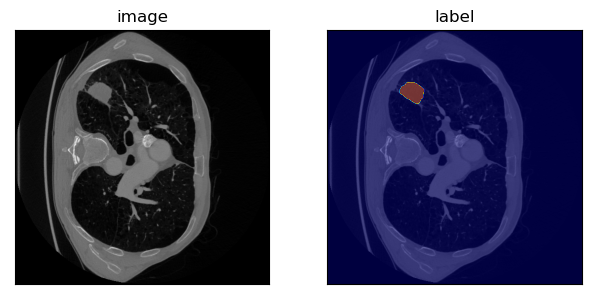

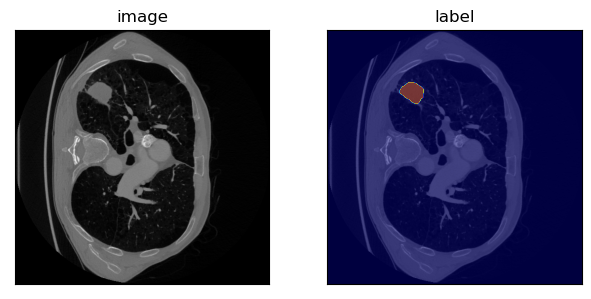

<Figure size 1200x400 with 0 Axes>

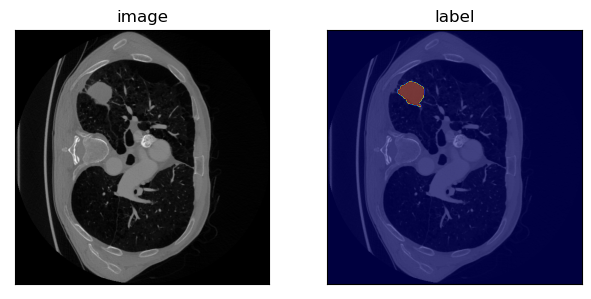

In [132]:
# Visualize check image and label

for slide in range(350, 353):#380):
  plt.figure("check", (12, 4))

  fig, axes = plt.subplots(1, 2)
  fig.tight_layout()

  for ax in axes:
      # Remove x and y ticks
      ax.set_xticks([])
      ax.set_yticks([])

  axes[0].set_title("image")
  axes[0].imshow(data_check['image'][:, :, slide], cmap = "gray")

  axes[1].set_title("label")
  axes[1].imshow(data_check['image'][:, :, slide], cmap = "gray")
  axes[1].imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)
  # fig.savefig(f'{images_path}gt014_slice{slide}.png')

## Load training set

In [139]:
# Set up transform
KEYS = ["image", "label"]
# transform = Compose([
#     LoadImageD(keys = KEYS),
#     EnsureChannelFirstD(keys = KEYS),
#     OrientationD(KEYS, axcodes='RAS'),
#     SpacingD(keys = KEYS,
#              pixdim = (1., 1., 1.),
#              mode = ('bilinear', 'nearest')),
#     ScaleIntensityD(keys = "image"),
#     ResizeD(KEYS,
#             (128, 128, 64),
#             mode=('trilinear', 'nearest')),
#     RandAffineD(keys = KEYS,
#                 spatial_size = (128, 128, 64),
#                 rotate_range = (0, 0, np.pi/12),
#                 scale_range = (0.1, 0.1, 0.1),
#                 mode = ('bilinear', 'nearest'),
#                 prob = 1.0),
#     ToTensorD(KEYS),
# ])

train_transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(keys=KEYS, axcodes='RAS'),
    SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    ScaleIntensityD(keys="image"),
    ResizeD(keys=KEYS, spatial_size=(IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS), mode=('trilinear', 'nearest')),
    # ResizeD(keys=KEYS, spatial_size=(128, 128, 64), mode=('trilinear', 'nearest')),

    RandAffineD(
        keys=KEYS,
        spatial_size= (IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS),

        # spatial_size=(128, 128, 64),
        rotate_range=(0, 0, np.pi/12),
        scale_range=(0.1, 0.1, 0.1),
        mode=('bilinear', 'nearest'),
        prob=0.5
    ),
    RandFlipD(keys=KEYS, spatial_axis=[0,1], prob=0.5),
    RandRotateD(keys=KEYS, range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.5),
    RandZoomD(keys=KEYS, min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensorD(keys=KEYS),
])

In [140]:
# Load data
train_name = 'training' # From Monai: ['training', 'validation', 'test']
dataset = DecathlonDataset(root_dir = f'{datasets_path}{train_name}/',
                           task = "Task06_Lung", section = train_name,
                           transform = train_transform, download = False)

train_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

Loading dataset: 100%|██████████| 51/51 [07:33<00:00,  8.89s/it]


In [142]:
# Check transformed data
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

# Trying to understand what the dimension 2 of the data is
print(training_image[0, :, 0, 0, 15])

Length of training set: 13
check data training image shape: torch.Size([4, 1, 16, 16, 16]) 
check data training label shape: torch.Size([4, 1, 16, 16, 16])
metatensor([0.])


In [143]:
def plot_ct_slices_from_loader_shape(plot_name, starting_idx, window_len, image, mask):
  plt.figure(plot_name, (12, 12))
  for slide in range(starting_idx, starting_idx + window_len):

    fig, axes = plt.subplots(1, 2)
    fig.tight_layout()

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    axes[0].set_title("image")
    axes[0].imshow(image[0, 0, :, :, slide], cmap = "gray")

    axes[1].set_title("label")
    axes[1].imshow(image[0, 0, :, :, slide], cmap = "gray")
    axes[1].imshow(mask[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)
  plt.show()

<Figure size 1200x1200 with 0 Axes>

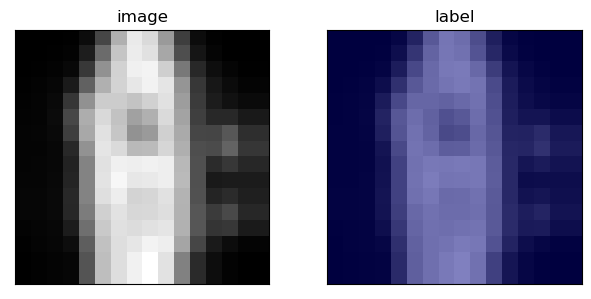

In [145]:
plot_ct_slices_from_loader_shape("Training Data", 15, 1, training_image, training_label)

## Load validation set

In [146]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS), mode=('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

val_name = 'validation'
val_dataset = DecathlonDataset(root_dir = f'{datasets_path}{val_name}/',
                           task = "Task06_Lung", section = val_name,
                           transform = val_transform, download = False)

val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

Loading dataset: 100%|██████████| 12/12 [01:47<00:00,  8.96s/it]


In [147]:
# Check transformed data
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

Length of validation set: 3
check data image shape: torch.Size([4, 1, 16, 16, 16]) 
check data label shape: torch.Size([4, 1, 16, 16, 16])


<Figure size 1200x1200 with 0 Axes>

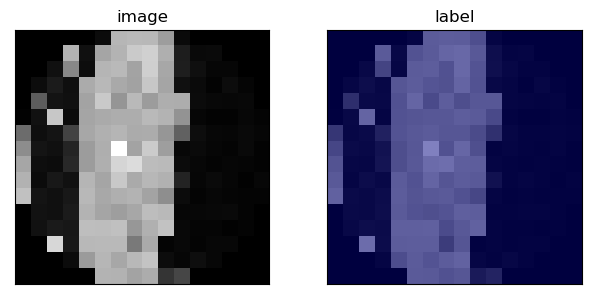

In [149]:
plot_ct_slices_from_loader_shape("Validation Data", 15, 1, val_image, val_label)

# Model, Loss, Optimizer

In [150]:
checkpoints_path = '/home/aimas/Desktop/Disertatie_CataChiru/checkpoints/UNET/'

best_model_name = checkpoints_path +  "best_dice_unet.pth"

In [6]:
LEARNING_RATE = 3e-3

loss_function = DiceLoss(to_onehot_y = True, softmax = True) # include_background=False

dice_metric = DiceMetric(include_background = False, reduction = "mean") # include_background = False,
iou_metric = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

In [11]:
UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (64, 128, 256, 512),
    strides = (2, 2, 2),
    # act = torch.nn.ReLU,
    dropout = 0.1
)

model = AttentionUnet(**UNet_metadata).to(device) # using UNet model

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE) # using Adam optimizer

decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [153]:
def pixel_accuracy_per_tensor(y_pred, y, threshold = 0.5, include_background=False):
    shape_pred = y_pred.shape
    shape_y = y.shape

    y_crt_pred = torch.zeros_like(y)

    if shape_pred != shape_y:
        y_crt_pred = y_pred[:, 1, :, :].clone()
    else:
        y_crt_pred = y_pred.clone()

    y_crt_pred[y_crt_pred > threshold] = 1
    y_crt_pred[y_crt_pred <= threshold] = 0

    return (y_crt_pred == y).sum() / y.numel()

def pixel_accuracy_per_batch(y_pred_batch, y_batch, threshold = 0.5, include_background=False):
    assert len(y_pred_batch) == len(y_batch)

    accuracies = []

    for i in range(len(y_pred_batch)):
      accuracies.append(pixel_accuracy_per_tensor(y_pred_batch[i], y_batch[i], threshold))

    return torch.tensor(accuracies)

def rvd_per_tensor(y_pred, y):
    shape_pred = y_pred.shape
    shape_y = y.shape

    y_crt_pred = torch.zeros_like(y)

    if shape_pred != shape_y:
        y_crt_pred = y_pred[:, 1, :, :].clone()
    else:
        y_crt_pred = y_pred.clone()

    return (y - y_crt_pred).sum() / y_crt_pred.sum()

def rvd_per_batch(y_pred_batch, y_batch, threshold = 0.5):
    assert len(y_pred_batch) == len(y_batch)

    rvds = []

    for i in range(len(y_pred_batch)):
      rvds.append(rvd_per_tensor(y_pred_batch[i], y_batch[i]))

    return torch.tensor(rvds)

In [154]:
for batch_data in train_loader:
  setup_input, setup_label = (
      batch_data["image"].to(device),
      batch_data["label"].to(device),
  )
  break

In [155]:
# Output shape
model(setup_input).shape, setup_label.shape

(torch.Size([4, 2, 16, 16, 16]), torch.Size([4, 1, 16, 16, 16]))

In [ ]:
# output_prime[:, 1, :, :, :].unsqueeze(dim=1).shape <- The Matrix corresponding to the segmentation mask: How good it predicts tumour existance 0 to 1

# Start training

In [156]:
import sys
import pickle as pkl

max_epochs = 20 # Set to 100 after adding the desired quantitative metrics: IoU, Pixel-accuracy, RVD and MSD (Symmetric Hausdorff Distance)
val_interval = 2 # Set to 5 or 10 afterwards

best_dice = -1
best_metrics = None
best_metric_epoch = -1

dice_values = []
iou_values = []
pixel_accuracy_values = []
rvd_values = []

epoch_loss_values = []

post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

for epoch in range(max_epochs):
  print("-" * 12)
  print(f"Epoch {epoch + 1}/{max_epochs}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    # # A common pytorch Deep Learning format to train model
    # optimizer.zero_grad()
    output = model(input)

    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():.4f}")

  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)

  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
    # Save current checkpoint of the network

    print(f"Saving checkpoint: {epoch//val_interval + 1} / {max_epochs//val_interval}!!!")
    name = checkpoints_path + f'unet_lr{LEARNING_RATE}_epoch{epoch}.pth'
    torch.save(model.state_dict(), name)

    # Turn model to "eval" mode
    model.eval()
    lr_scheduler.step()

    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True
    with torch.no_grad():
      iteration_ious = []
      iteration_pixel_accuracies = []
      iteration_rvds = []

      for val_data in val_loader:
        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )

        roi_size = (128, 128, 96)
        sw_batch_size = 1

        # Set AMP for MONAI validation
        val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
        val_output = [post_pred(i) for i in decollate_batch(val_output)]
        val_label = [post_label(i) for i in decollate_batch(val_label)]


        # Compute metrics for current iteration
        dice_metric(y_pred = val_output, y = val_label)
        iou_metric(y_pred=val_output, y=val_label)
        iteration_pixel_accuracies.append(pixel_accuracy_per_batch(val_output, val_label).mean().item())
        iteration_rvds.append(rvd_per_batch(val_output, val_label).mean().item())

      # Aggregate the final mean results
      dice_score = dice_metric.aggregate().item()
      mean_iou = iou_metric.aggregate().item()
      mean_pix_acc = torch.mean(torch.tensor(iteration_pixel_accuracies))
      mean_rvd = torch.mean(torch.tensor(iteration_rvds))

      # Reset the status for the next epoch
      dice_metric.reset()
      iou_metric.reset()

      dice_values.append(dice_score)
      iou_values.append(mean_iou)
      pixel_accuracy_values.append(mean_pix_acc)
      rvd_values.append(mean_rvd)

      if dice_score > best_dice:
        best_dice = dice_score
        best_metrics = (dice_score, mean_iou, mean_pix_acc, mean_rvd)
        best_metric_epoch = epoch + 1
        print("saved new best metric model!!!")

        torch.save(model.state_dict(), best_model_name)

      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {dice_score:.4f},"
          f" current mean iou: {mean_iou:.4f},"
          f" current mean pix acc: {mean_pix_acc:.4f},"
          f" current mean rvd: {mean_rvd:.4f},"
          f" best mean dice: {best_dice:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

print(
    f"train completed, metrics correspondic to best dice are: dice: {best_metrics[0]:.4f}, iou: {best_metrics[1]:.4f}, acc: {best_metrics[2]:.4f}, rvd: {best_metrics[3]:.4f}"
    f" at epoch: {best_metric_epoch}"
)

with open(checkpoints_path + 'metrics_evolution.pkl', 'wb') as f:
    pkl.dump((dice_values, iou_values, pixel_accuracy_values, rvd_values, epoch_loss_values), f)

------------
Epoch 1/20
1/12, train_loss: 0.6607
2/12, train_loss: 0.6435
3/12, train_loss: 0.6340
4/12, train_loss: 0.6255
5/12, train_loss: 0.6170
6/12, train_loss: 0.6097
7/12, train_loss: 0.6038
8/12, train_loss: 0.5971
9/12, train_loss: 0.5911
10/12, train_loss: 0.5841
11/12, train_loss: 0.5794
12/12, train_loss: 0.5745
13/12, train_loss: 0.5695
epoch 1 average loss: 0.6069
------------
Epoch 2/20
1/12, train_loss: 0.5646
2/12, train_loss: 0.5612
3/12, train_loss: 0.5560
4/12, train_loss: 0.5507
5/12, train_loss: 0.5460
6/12, train_loss: 0.5418
7/12, train_loss: 0.5377
8/12, train_loss: 0.5331
9/12, train_loss: 0.5306
10/12, train_loss: 0.5283
11/12, train_loss: 0.5243
12/12, train_loss: 0.5234
13/12, train_loss: 0.5206
epoch 2 average loss: 0.5399
Saving checkpoint: 1 / 10!!!
saved new best metric model!!!
current epoch: 2, current mean dice: 0.0000, current mean iou: 0.0000, current mean pix acc: 0.9694, current mean rvd: 0.0000, best mean dice: 0.0000, at epoch: 2
------------


In [ ]:
with open(checkpoints_path + 'metrics_evolution.pkl', 'rb') as f:
    logs_tuple = pkl.load(f)

    losses_vals = logs_tuple[-1]
    print(losses_vals)

# Check model and Visualize

In [ ]:
print(
    f"train completed, best_metric: {best_dice:.4f} "
    f"at epoch: {best_metric_epoch}")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)


plt.title("Val Mean Dice") # <- Se schimba si asta
x = [val_interval * (i + 1) for i in range(len(dice_values))]
y = dice_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(images_path + 'model_03_graph.png')
plt.show()
# plt.savefig(PATH_NAME+'model.png')

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Val Mean IoU")
x = [i + 1 for i in range(len(iou_values))]
y = iou_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)


plt.title("Val Pixel Acc") # <- Se schimba si asta
x = [val_interval * (i + 1) for i in range(len(pixel_accuracy_values))]
y = pixel_accuracy_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(images_path + 'model_03_graph2.png')
plt.show()
# plt.savefig(PATH_NAME+'model.png')

In [ ]:
checker = first(val_loader)
image, label = checker['image'], checker['label']

In [ ]:
plot_ct_slices_from_loader_shape("Test Model", 28, 1, image, label)
# plt.show()

In [ ]:
model.cpu()
model.load_state_dict(torch.load(best_model_name))

with torch.no_grad():
  output = model(image)
  output = torch.nn.Softmax()(output)
  output = torch.round(output)

  print(f"Output shape: {output.shape}")

  slide = 28
  plt.figure("Test Model", (12, 12))

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

  plt.subplot(1, 3, 2)
  plt.title("Label")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.subplot(1, 3, 3)
  plt.title("Output")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.show()

In [ ]:
def predict(image, label, model, architecture_name, single_patient = True, wanted_slide=29):
    with torch.no_grad():
      output = model(image)
      output = torch.nn.Softmax()(output)
      output = torch.round(output)

      print(f"Output shape: {output.shape}")

      if single_patient:
        start_slide = 0
        window_length = image.shape[-1]
      else:
        start_slide = wanted_slide
        window_length = 1

      for slide in range(start_slide, start_slide+window_length):
        plt.figure("Test Model", (12, 12))

        plt.subplot(1, 3, 1)
        plt.title("Input")
        plt.axis('off')

        plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.axis('off')
        plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
        plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.title(architecture_name)
        plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
        plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

        plt.show()

In [ ]:
from tqdm import tqdm

it = iter(val_loader)
for i in tqdm(range(len(val_dataset))):
  # checker = next(val_loader)
  checker = first(val_loader)
  image, label = checker['image'], checker['label']
  predict(image, label, model, 'Attention-UNet', single_patient = False)

In [12]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    # Get the total number of parameters as millions
    print(f"Total Trainable Params: {total_params/1e6:.2f} M params")
    return total_params
    
count_parameters(model)

+---------------------------------------------------------------+------------+
|                            Modules                            | Parameters |
+---------------------------------------------------------------+------------+
|                   model.0.conv.0.conv.weight                  |    1728    |
|                    model.0.conv.0.conv.bias                   |     64     |
|                  model.0.conv.0.adn.N.weight                  |     64     |
|                   model.0.conv.0.adn.N.bias                   |     64     |
|                   model.0.conv.1.conv.weight                  |   110592   |
|                    model.0.conv.1.conv.bias                   |     64     |
|                  model.0.conv.1.adn.N.weight                  |     64     |
|                   model.0.conv.1.adn.N.bias                   |     64     |
|              model.1.attention.W_g.0.conv.weight              |    2048    |
|               model.1.attention.W_g.0.conv.bias   

23431918